### Feature Importance - Random Forest

In [36]:
import pandas as pd
import yfinance as yf
from datetime import datetime
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [21]:
plt.rcParams['figure.figsize'] = (16, 6)

# define dataset
start_date = datetime(2020,1,1)
end_date = datetime(2025,1,1)

stock_symbol = 'GS'
stock = yf.download(stock_symbol, start_date, end_date)
STOCK_raw = stock.xs(stock_symbol, axis = 1, level = 'Ticker')
STOCK_raw.describe()
STOCK = STOCK_raw.copy()

[*********************100%***********************]  1 of 1 completed


In [22]:
DATA_raw = pd.read_csv('GS_FeatureMart_New.csv')
DATA_raw.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF,SP500,T10YIE,DEXUSUK,DEXUSEU,...,BAMLH0A0HYM2,AMERIBOR,T10Y2Y,DGS30,EFFR,SMA_10,RSI_15,BBL_10_2.0,BBP_10_2.0,OBV
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1214.000000,1208.000000,1206.000000,1206.000000,...,1246.000000,1255.000000,1208.000000,1208.000000,1213.000000,1248.000000,1242.000000,1248.000000,1248.000000,1.257000e+03
mean,0.052607,-0.007114,-0.001638,0.025700,0.001232,0.009312,4198.032562,2.180596,1.284108,1.110020,...,4.191372,1.311758,0.174197,2.989536,2.376158,320.922989,53.735077,307.677504,0.539615,2.016314e+07
std,1.378205,0.833110,1.146223,0.653529,0.575492,0.009191,708.144093,0.411014,0.066444,0.058172,...,1.169591,1.794239,0.688597,1.158016,2.330200,95.076592,11.645103,93.522433,0.320398,3.244227e+07
min,-12.000000,-4.550000,-4.970000,-2.180000,-2.740000,0.000000,2237.400000,0.500000,1.070300,0.961600,...,2.890000,0.000000,-1.080000,0.990000,0.040000,133.678775,21.511343,109.699159,-0.154830,-5.531940e+07
25%,-0.530000,-0.520000,-0.660000,-0.380000,-0.330000,0.000000,3800.005000,2.137500,1.240600,1.074750,...,3.322500,0.096154,-0.410000,1.920000,0.080000,282.494218,46.016352,268.028414,0.269830,-4.371700e+06
50%,0.070000,-0.020000,-0.040000,0.010000,-0.020000,0.006000,4183.570000,2.300000,1.274950,1.095700,...,3.890000,0.134391,0.170000,3.040000,1.580000,318.893596,53.375340,304.430840,0.571433,1.051520e+07
75%,0.755000,0.450000,0.620000,0.440000,0.360000,0.020000,4550.267500,2.390000,1.332575,1.161125,...,4.690000,2.449060,0.702500,4.070000,5.080000,362.272458,62.104356,348.887127,0.812368,4.898010e+07
max,9.340000,5.720000,6.730000,4.210000,2.520000,0.022000,5864.670000,3.020000,1.418800,1.229500,...,10.870000,5.392250,1.590000,5.110000,5.330000,597.972516,85.598279,593.354877,1.232384,1.039735e+08


In [23]:
DATA = DATA_raw.copy()
# NORMALIZATION
for column in DATA_raw.columns[1:]:
    DATA[column] = (DATA_raw[column] -
                           DATA_raw[column].mean()) / DATA_raw[column].std()

In [24]:
for column in STOCK_raw.columns[1:]:
    STOCK[column] = (STOCK_raw[column] -
                           STOCK_raw[column].mean()) / STOCK_raw[column].std()

In [25]:
DATA.head()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF,SP500,T10YIE,DEXUSUK,...,BAMLH0A0HYM2,AMERIBOR,T10Y2Y,DGS30,EFFR,SMA_10,RSI_15,BBL_10_2.0,BBP_10_2.0,OBV
0,1/02/20,0.585829,-1.155772,-0.286473,0.327913,-0.384423,-0.360321,-1.327671,-0.925993,0.431830,...,-0.539823,0.163249,0.182695,-0.569540,-0.354544,NaN,NaN,NaN,NaN,-0.506341
1,1/03/20,-0.524311,0.368636,0.001429,-0.238244,-0.193282,-0.360321,-1.360151,-0.998983,0.376144,...,-0.497073,0.162572,0.139128,-0.629988,-0.354544,NaN,NaN,NaN,NaN,-0.576450
2,1/06/20,0.223038,-0.243528,-0.478408,-0.299451,-0.453928,-0.360321,-1.344010,-1.047644,0.484506,...,-0.531273,0.160366,0.139128,-0.612717,-0.354544,NaN,NaN,NaN,NaN,-0.473827
3,1/07/20,-0.176031,-0.027470,-0.216679,-0.238244,-0.419175,-0.360321,-1.356860,-1.071974,0.430325,...,-0.556923,0.160366,0.168172,-0.586811,-0.354544,NaN,NaN,NaN,NaN,-0.311841
4,1/08/20,0.302852,-0.183512,-0.574376,-0.284149,-0.314917,-0.360321,-1.334450,-1.047644,0.404740,...,-0.591123,0.160366,0.168172,-0.552269,-0.354544,NaN,NaN,NaN,NaN,-0.201963


In [13]:
DATA.columns

Index(['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'SP500', 'T10YIE',
       'DEXUSUK', 'DEXUSEU', 'T10Y3M', 'T5YIE', 'DBAA', 'DAAA',
       'BAMLH0A0HYM2EY', 'BAMLH0A0HYM2', 'AMERIBOR', 'T10Y2Y', 'DGS30', 'EFFR',
       'SMA_10', 'RSI_15', 'BBL_10_2.0', 'BBP_10_2.0', 'OBV'],
      dtype='object')

In [26]:
X = DATA.drop(columns = ['Date']).bfill()
y = STOCK['Close']
# y = np.diff(np.log(STOCK['Close'].values))
# y = np.append(y[0], y)

In [27]:
# define the model
model = RandomForestRegressor(bootstrap=True, criterion='squared_error', max_depth=None,\
           max_features=5, max_leaf_nodes=None,\
           min_impurity_decrease=0.0,\
           min_samples_leaf = 1, min_samples_split=2,\
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,\
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [28]:
y.tail()

,Close
Date,
2024-12-24,579.914368
2024-12-26,578.362061
2024-12-27,573.337036
2024-12-30,570.719971
2024-12-31,569.794556


In [29]:
# fit the model
model.fit(X, y)

RandomForestRegressor(max_features=5)

In [30]:
# 1. average feature importance
df_feature_importance = pd.DataFrame(model.feature_importances_, index=X.columns, \
                                     columns=['feature importance']).sort_values('feature importance', ascending=False)
print(df_feature_importance)

                feature importance
SMA_10                    0.255344
SP500                     0.123425
BBL_10_2.0                0.122437
T10YIE                    0.094515
AMERIBOR                  0.092439
T5YIE                     0.063876
DGS30                     0.048183
BAMLH0A0HYM2              0.035081
DAAA                      0.032680
OBV                       0.031098
EFFR                      0.021791
RF                        0.018042
BAMLH0A0HYM2EY            0.016588
T10Y3M                    0.012495
T10Y2Y                    0.010940
DEXUSUK                   0.006476
DBAA                      0.005244
RSI_15                    0.004125
DEXUSEU                   0.003094
BBP_10_2.0                0.001238
Mkt-RF                    0.000278
CMA                       0.000180
HML                       0.000154
RMW                       0.000152
SMB                       0.000125


In [31]:
# 2. all feature importance for each tree
df_feature_all = pd.DataFrame([tree.feature_importances_ for tree in model.estimators_], columns=X.columns)
df_feature_all.head()
# Melted data i.e., long format
df_feature_long = pd.melt(df_feature_all,var_name='feature name', value_name='values')
print(df_feature_long.iloc[0:104])

    feature name    values
0         Mkt-RF  0.000143
1         Mkt-RF  0.000969
2         Mkt-RF  0.000075
3         Mkt-RF  0.000584
4         Mkt-RF  0.000070
..           ...       ...
99        Mkt-RF  0.000416
100          SMB  0.000108
101          SMB  0.000100
102          SMB  0.000218
103          SMB  0.000118

[104 rows x 2 columns]


<Axes: >

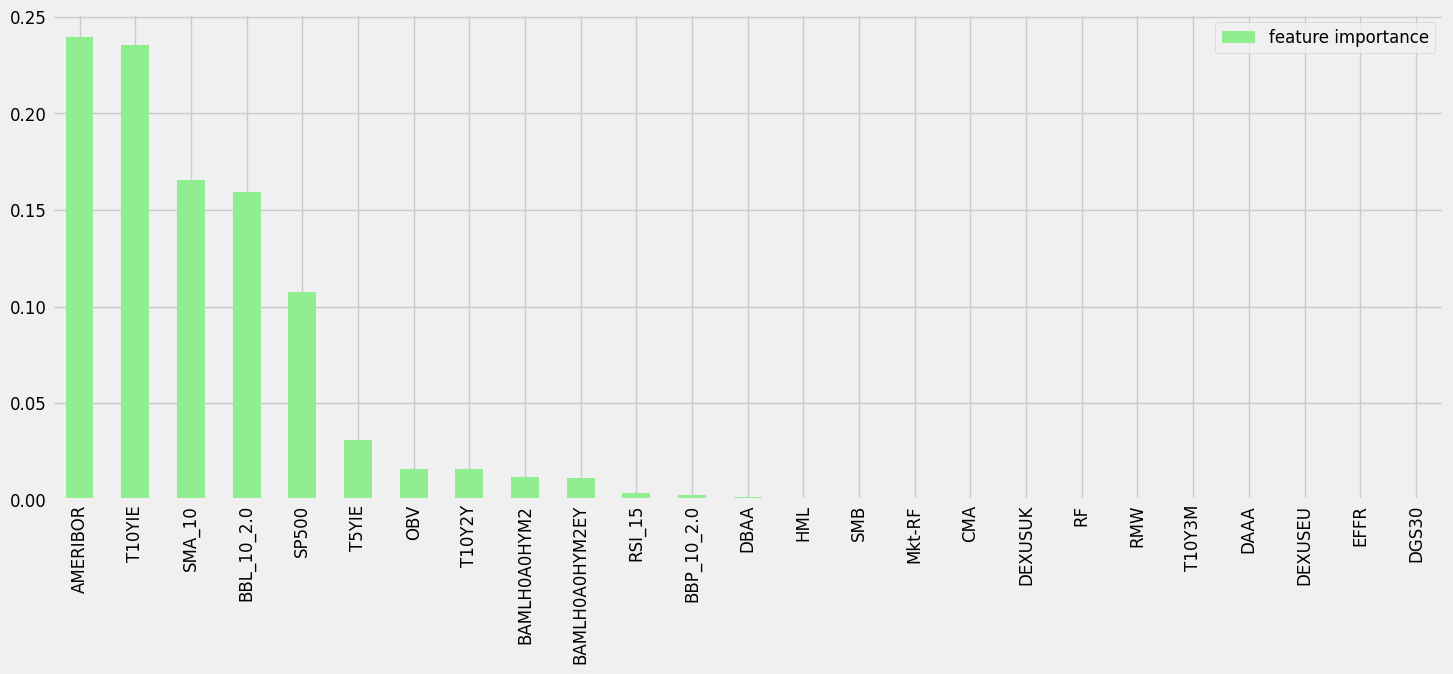

In [44]:
# 3. visualize feature importance (run each line sequentially)
# (1) bar chart
df_feature_importance.plot(kind='bar', color = 'lightgreen')

<Axes: xlabel='feature name', ylabel='values'>

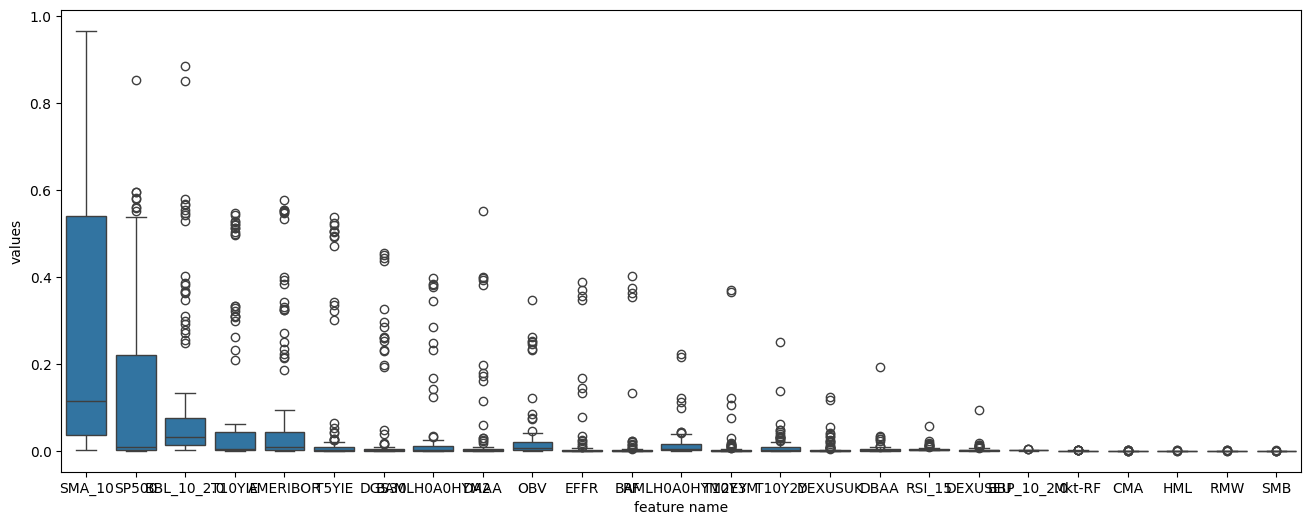

In [33]:
# (2) box plot
sns.boxplot(x="feature name", y="values", data=df_feature_long, order=df_feature_importance.index)

<Axes: xlabel='feature name', ylabel='values'>

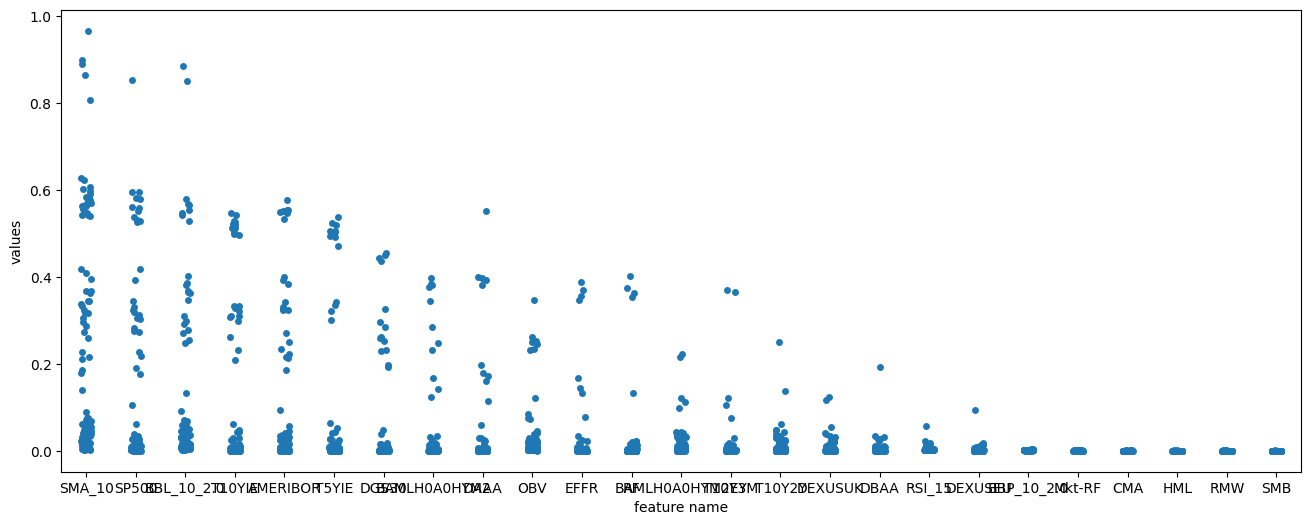

In [34]:
# (3) strip plot
sns.stripplot(x="feature name", y="values", data=df_feature_long, order=df_feature_importance.index)

### Feature Importance - XGBoost

In [37]:
min_cols = 3
model = xgb.XGBRegressor(objective ='reg:squarederror',
                         n_estimators=20,
                          learning_rate = 0.05,
                          max_depth = min_cols,
                          alpha = 10,
                          eta=0.1,
                          subsample = 0.7,
                          colsample_bytree=0.8,
                          reg_lambda=1,
                          gamma=0)
# fit the model
model.fit(X, y)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=20,
             n_jobs=None, ...)

In [38]:
# 1. average feature importance
df_feature_importance = pd.DataFrame(model.feature_importances_, index=X.columns, \
                                     columns=['feature importance']).sort_values('feature importance', ascending=False)
print(df_feature_importance)

                feature importance
AMERIBOR                  0.239520
T10YIE                    0.235083
SMA_10                    0.165371
BBL_10_2.0                0.159442
SP500                     0.107633
T5YIE                     0.030860
OBV                       0.016123
T10Y2Y                    0.015691
BAMLH0A0HYM2              0.011874
BAMLH0A0HYM2EY            0.011155
RSI_15                    0.003356
BBP_10_2.0                0.002674
DBAA                      0.001217
HML                       0.000000
SMB                       0.000000
Mkt-RF                    0.000000
CMA                       0.000000
DEXUSUK                   0.000000
RF                        0.000000
RMW                       0.000000
T10Y3M                    0.000000
DAAA                      0.000000
DEXUSEU                   0.000000
EFFR                      0.000000
DGS30                     0.000000


<Axes: >

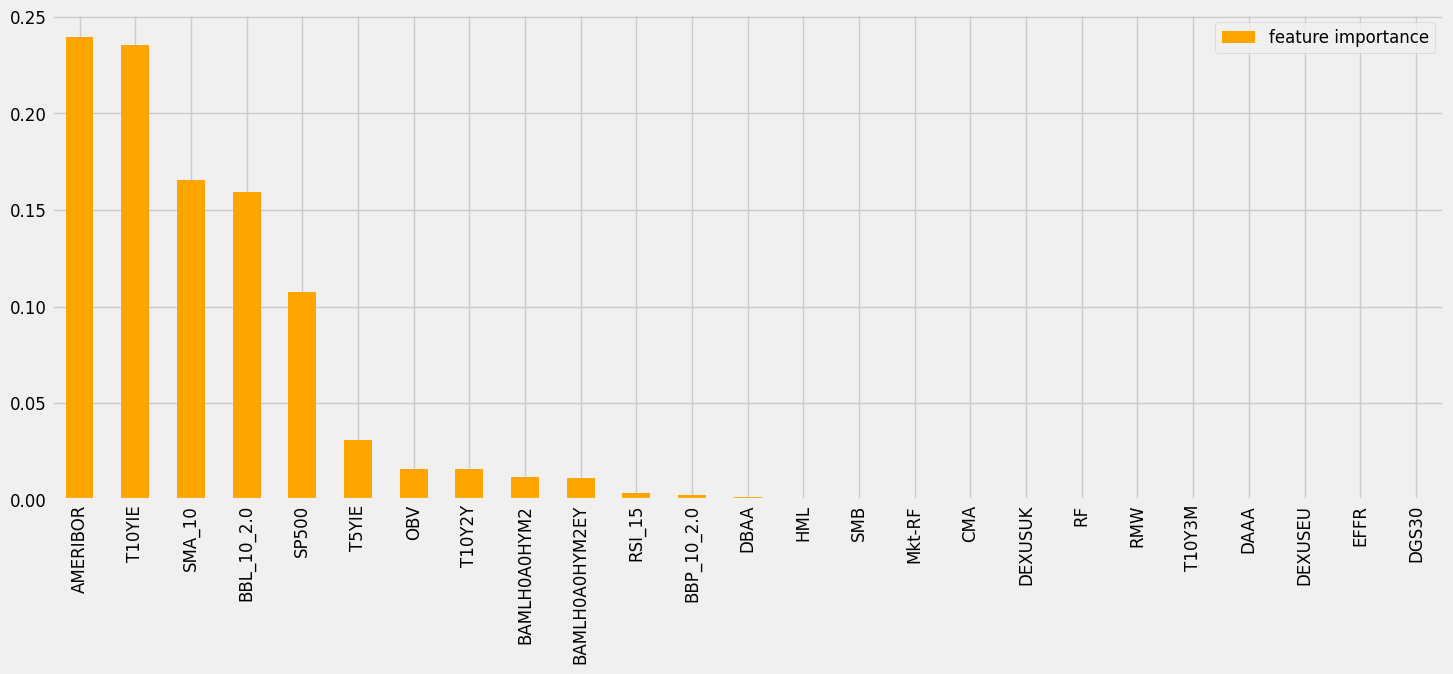

In [46]:
# 2. visualize feature importance (run each line sequentially)
# (1) bar chart
df_feature_importance.plot(kind='bar', color = 'orange')

The best hyperparameters are  {'learning_rate': 0.15, 'max_depth': 10, 'n_estimators': 100}


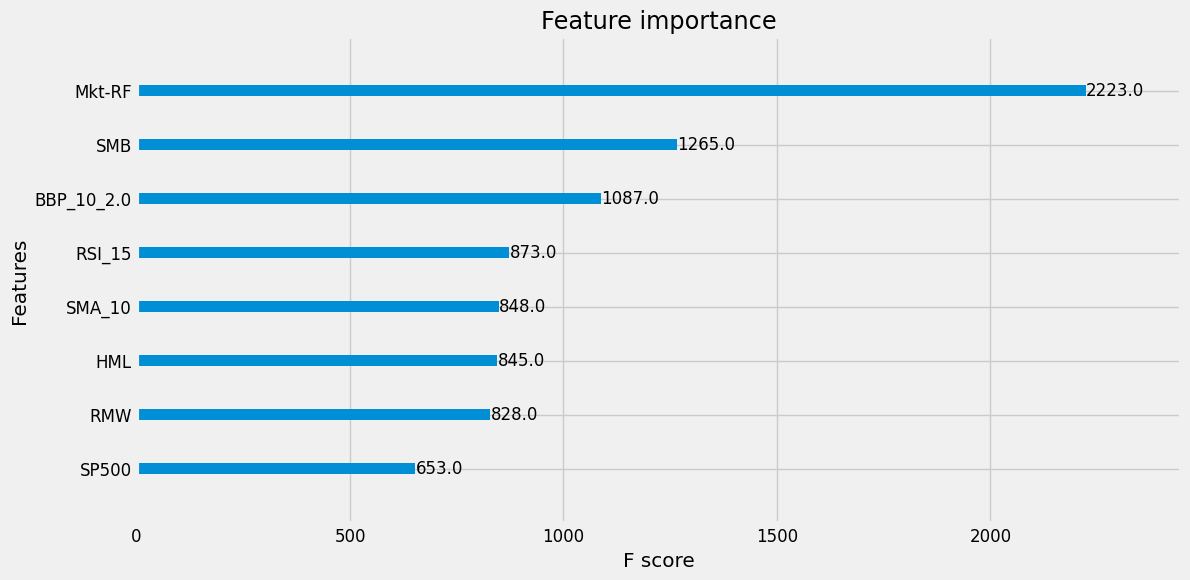

In [47]:
# exhaustively search for the optimal hyperparameters
from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [3, 5, 10],
              "n_estimators": [10, 50, 100],
              "learning_rate": [0.15, 0.3]}

regressor = xgb.XGBRegressor(eval_metric='rmsle')
search = GridSearchCV(regressor, param_grid, cv=5).fit(X, y)

print("The best hyperparameters are ",search.best_params_)
regressor = xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],)

regressor.fit(X, y)


from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=8, ax=ax)
plt.show()

### Feature Selection - Gradient Booster Regression

                feature importance
AMERIBOR                  0.579326
SMA_10                    0.374900
BBL_10_2.0                0.019779
T10YIE                    0.008214
OBV                       0.006570
SP500                     0.003818
BBP_10_2.0                0.003711
RSI_15                    0.002474
BAMLH0A0HYM2              0.000199
T10Y3M                    0.000133
Mkt-RF                    0.000128
BAMLH0A0HYM2EY            0.000106
DEXUSUK                   0.000095
RF                        0.000094
DAAA                      0.000087
DEXUSEU                   0.000078
T10Y2Y                    0.000061
T5YIE                     0.000057
DGS30                     0.000040
RMW                       0.000032
DBAA                      0.000025
HML                       0.000023
CMA                       0.000023
SMB                       0.000022
EFFR                      0.000005


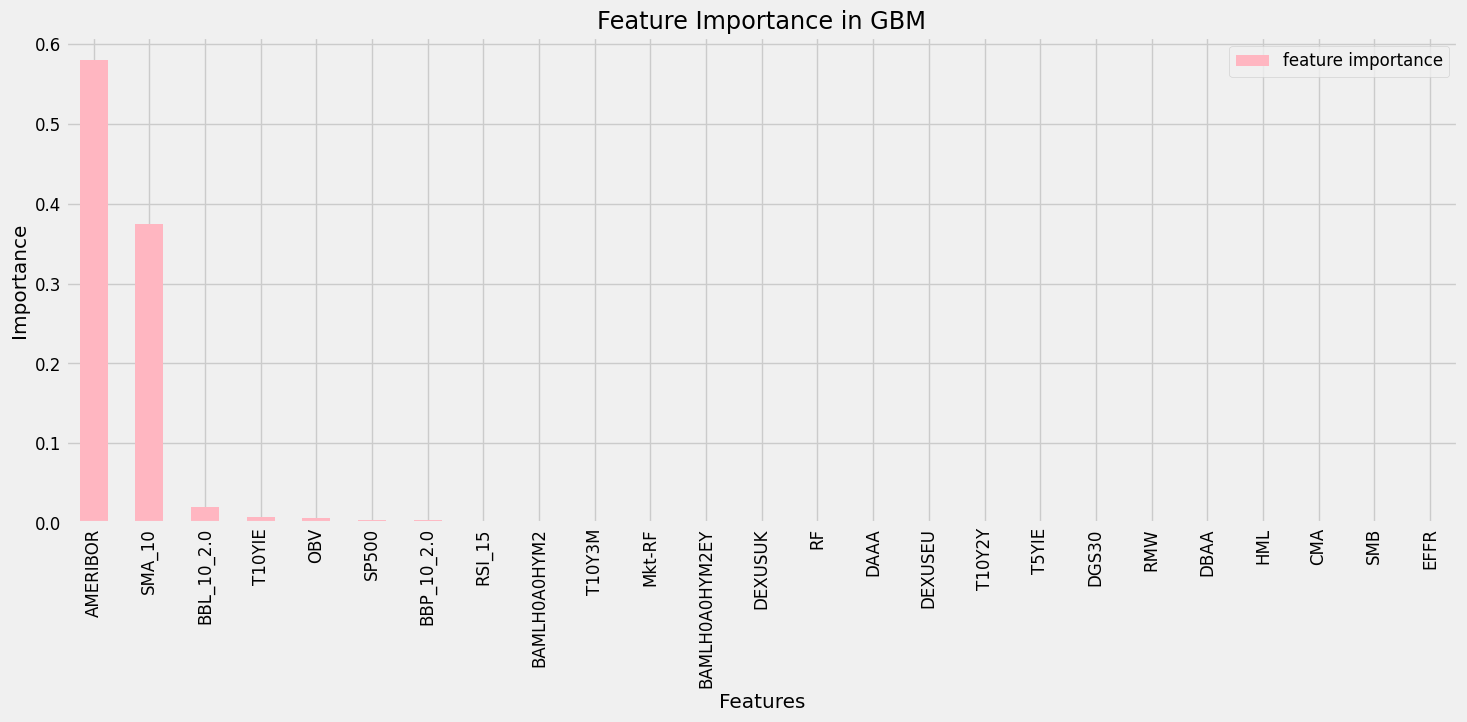

In [54]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Assuming DATA is your features DataFrame and STOCK['Close'] is your target variable
X = DATA.drop(columns=['Date'])
y = STOCK['Close']

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Initialize the GBM model
model = GradientBoostingRegressor(
    loss='squared_error',
    learning_rate=0.1,
    n_estimators=100,
    subsample=1.0,
    criterion='friedman_mse',
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=None,
    min_impurity_decrease=0.0,
    random_state=None,
    max_features=None,
    verbose=0,
    warm_start=False
)

# Fit the model
model.fit(X, y)

# Feature Importance
feature_importance = pd.DataFrame(model.feature_importances_, index=DATA.drop(columns=['Date']).columns, columns=['feature importance'])
feature_importance = feature_importance.sort_values('feature importance', ascending=False)

# Print feature importance
print(feature_importance)

# Visualization
feature_importance.plot(kind='bar', color='lightpink')
plt.title('Feature Importance in GBM')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()